<a href="https://colab.research.google.com/github/KingMZ01/Forecasting-system/blob/main/Using_AI_Forecasting_system_that_predicts_AQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City Air Quality Forecasting

## Step 1 —Environment setup + get the data (Kaggle)

### A —Install libraries (Colab cell)

In [77]:
# Colab cell 1: install essentials (run)
!pip install --quiet kaggle pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm plotly folium


### B —Add your Kaggle API token

In [78]:
# Colab cell 2: upload kaggle.json (run)
from google.colab import files
uploaded = files.upload()   # choose the kaggle.json file you downloaded from your Kaggle account


Saving kaggle.json to kaggle (3).json


In [79]:
# move it to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [80]:
# test kaggle config
!kaggle --version


Kaggle API 1.7.4.5


### C —Download a Kaggle dataset

In [81]:
# Search Kaggle for datasets related to India air quality
!kaggle datasets list -s "Air Quality Data in India"

# Download the 2015–2024 dataset (adjust slug if needed)
!kaggle datasets download -d ankushpanday1/air-quality-data-in-india-2015-2024 -p /content/data/ --unzip

# List contents to confirm download
!ls -lh /content/data

ref                                                              title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
rohanrao/air-quality-data-in-india                               Air Quality Data in India (2015 - 2020)              76469579  2020-07-28 12:33:10.347000          70855        600  1.0              
shrutibhargava94/india-air-quality-data                          India Air Quality Data                                5471432  2017-07-22 05:04:57.590000          36248        401  0.85294116       
fedesoriano/air-quality-data-in-india                            Air Quality Data in India (2017 - 2022)                276217  2022-06-04 18:04:03.957000           8594         78  1.0              


### D —Load the downloaded Kaggle CSV into pandas & quick peek

In [82]:
import pandas as pd

df_city = pd.read_csv("/content/data/city_day.csv", low_memory=False)

print("Shape:", df_city.shape)
print(df_city.columns.tolist())  # list of column names
df_city.head()

Shape: (18265, 16)
['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']


,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,2015-01-01,153.3,241.7,182.9,33.0,81.3,38.5,1.87,64.5,83.6,18.93,20.81,8.32,204.5,Severe
1,Mumbai,2015-01-01,70.5,312.7,195.0,42.0,122.5,31.5,7.22,83.8,108.0,2.01,19.41,2.86,60.9,Satisfactory
2,Chennai,2015-01-01,174.1,275.4,56.2,68.8,230.9,28.5,8.56,60.8,43.9,19.07,10.19,9.63,486.5,Severe
3,Kolkata,2015-01-01,477.2,543.9,14.1,76.4,225.9,45.6,2.41,42.1,171.1,9.31,11.65,9.39,174.4,Very Poor
4,Bangalore,2015-01-01,171.6,117.7,123.3,12.4,61.9,49.7,1.26,79.7,164.3,6.04,12.74,9.59,489.7,Good


## Step 2 —Basic Preprocessing

### Converted Datetime to proper type

In [83]:
# Corrected load with proper date parsing
df_city = pd.read_csv(
    "/content/data/city_day.csv",
    parse_dates=["Datetime"],
    low_memory=False
)

print("Shape:", df_city.shape)
print(df_city.dtypes)  # check types
df_city.head()


Shape: (18265, 16)
City                  object
Datetime      datetime64[ns]
PM2.5                float64
PM10                 float64
NO                   float64
NO2                  float64
NOx                  float64
NH3                  float64
CO                   float64
SO2                  float64
O3                   float64
Benzene              float64
Toluene              float64
Xylene               float64
AQI                  float64
AQI_Bucket            object
dtype: object


,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,2015-01-01,153.3,241.7,182.9,33.0,81.3,38.5,1.87,64.5,83.6,18.93,20.81,8.32,204.5,Severe
1,Mumbai,2015-01-01,70.5,312.7,195.0,42.0,122.5,31.5,7.22,83.8,108.0,2.01,19.41,2.86,60.9,Satisfactory
2,Chennai,2015-01-01,174.1,275.4,56.2,68.8,230.9,28.5,8.56,60.8,43.9,19.07,10.19,9.63,486.5,Severe
3,Kolkata,2015-01-01,477.2,543.9,14.1,76.4,225.9,45.6,2.41,42.1,171.1,9.31,11.65,9.39,174.4,Very Poor
4,Bangalore,2015-01-01,171.6,117.7,123.3,12.4,61.9,49.7,1.26,79.7,164.3,6.04,12.74,9.59,489.7,Good


### Filter only your 15–20 cities of interest

In [84]:
# Select top cities of interest
selected_cities = [
    "Delhi", "Mumbai", "Bangalore", "Chennai", "Kolkata",
    "Pune", "Hyderabad", "Ahmedabad", "Jaipur", "Lucknow",
    "Bhopal", "Patna", "Chandigarh", "Agra", "Kanpur"
]

df_filtered = df_city[df_city["City"].isin(selected_cities)].copy()

print("Shape after filtering:", df_filtered.shape)
print("Unique cities left:", df_filtered["City"].unique())
df_filtered.head()


Shape after filtering: (18265, 16)
Unique cities left: ['Delhi' 'Mumbai' 'Chennai' 'Kolkata' 'Bangalore']


,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,2015-01-01,153.3,241.7,182.9,33.0,81.3,38.5,1.87,64.5,83.6,18.93,20.81,8.32,204.5,Severe
1,Mumbai,2015-01-01,70.5,312.7,195.0,42.0,122.5,31.5,7.22,83.8,108.0,2.01,19.41,2.86,60.9,Satisfactory
2,Chennai,2015-01-01,174.1,275.4,56.2,68.8,230.9,28.5,8.56,60.8,43.9,19.07,10.19,9.63,486.5,Severe
3,Kolkata,2015-01-01,477.2,543.9,14.1,76.4,225.9,45.6,2.41,42.1,171.1,9.31,11.65,9.39,174.4,Very Poor
4,Bangalore,2015-01-01,171.6,117.7,123.3,12.4,61.9,49.7,1.26,79.7,164.3,6.04,12.74,9.59,489.7,Good


### Resampled to monthly averages for plotting

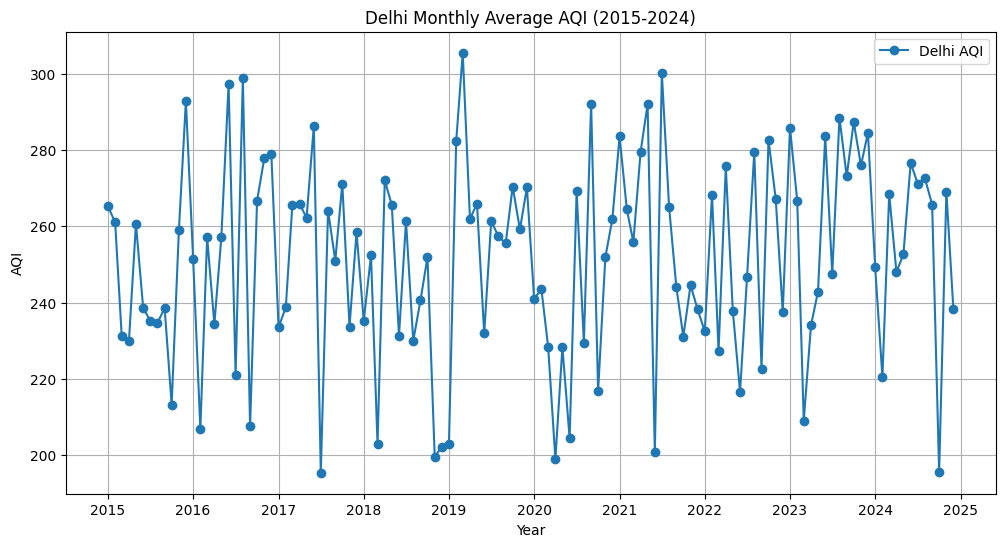

In [85]:
import matplotlib.pyplot as plt

# Filter the dataframe for Delhi
df_delhi = df_filtered[df_filtered["City"] == "Delhi"].copy()

# Resample to monthly average AQI (month start)
df_delhi_monthly = df_delhi.set_index("Datetime")["AQI"].resample("MS").mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_delhi_monthly.index, df_delhi_monthly.values, marker="o", label="Delhi AQI")
plt.title("Delhi Monthly Average AQI (2015-2024)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

### Smooth Delhi’s AQI

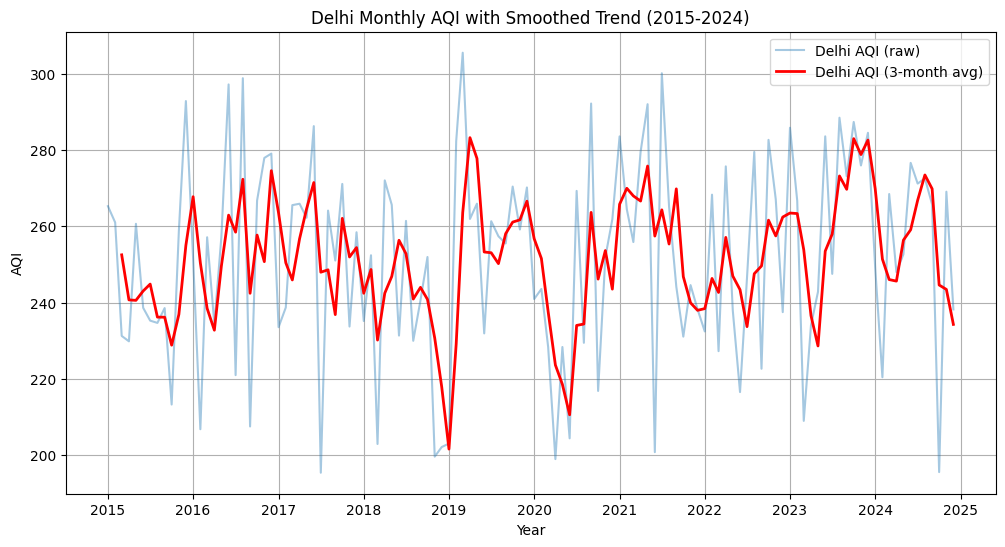

In [86]:
# 3-month rolling mean
df_delhi_monthly_smooth = df_delhi_monthly.rolling(window=3).mean()

plt.figure(figsize=(12,6))
plt.plot(df_delhi_monthly.index, df_delhi_monthly.values, alpha=0.4, label="Delhi AQI (raw)")
plt.plot(df_delhi_monthly_smooth.index, df_delhi_monthly_smooth.values,
         color="red", linewidth=2, label="Delhi AQI (3-month avg)")

plt.title("Delhi Monthly AQI with Smoothed Trend (2015-2024)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()


### Compare All 15 Cities

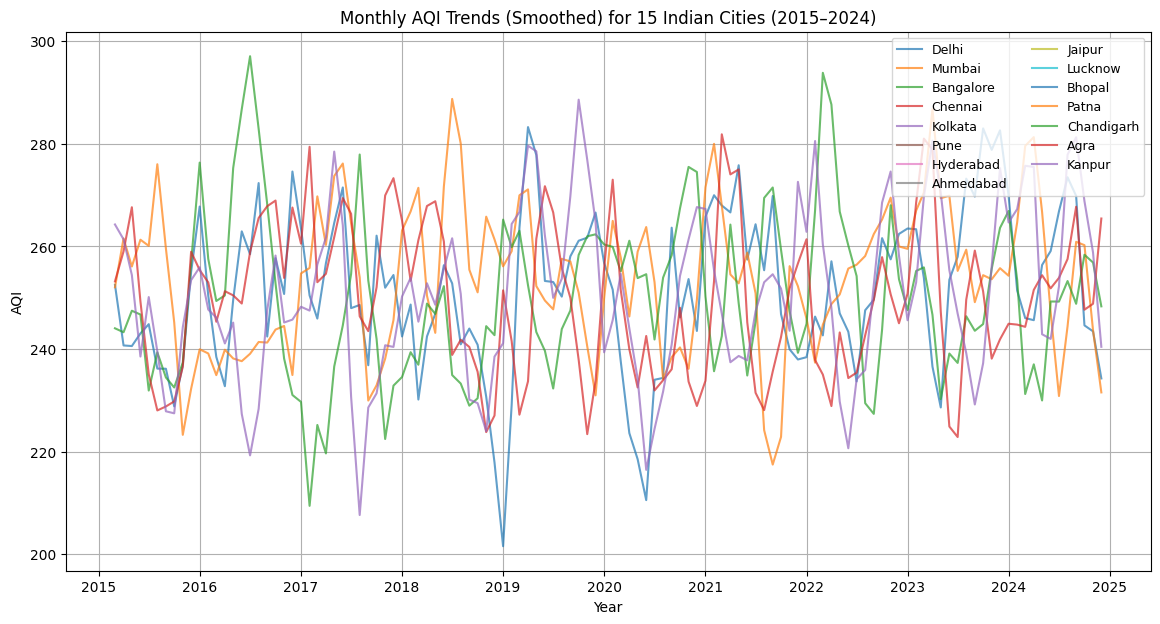

In [87]:
cities = ["Delhi", "Mumbai", "Bangalore", "Chennai", "Kolkata",
          "Pune", "Hyderabad", "Ahmedabad", "Jaipur", "Lucknow",
          "Bhopal", "Patna", "Chandigarh", "Agra", "Kanpur"]

plt.figure(figsize=(14,7))

for city in cities:
    df_city_temp = df_city[df_city["City"] == city]
    df_city_monthly = df_city_temp.set_index("Datetime")["AQI"].resample("MS").mean()
    df_city_smooth = df_city_monthly.rolling(window=3).mean()
    plt.plot(df_city_smooth.index, df_city_smooth.values, label=city, alpha=0.7)

plt.title("Monthly AQI Trends (Smoothed) for 15 Indian Cities (2015–2024)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.legend(loc="upper right", ncol=2, fontsize=9)
plt.grid(True)
plt.show()


### Yearly Average AQI by City (2015–2024)

<Figure size 1500x800 with 0 Axes>

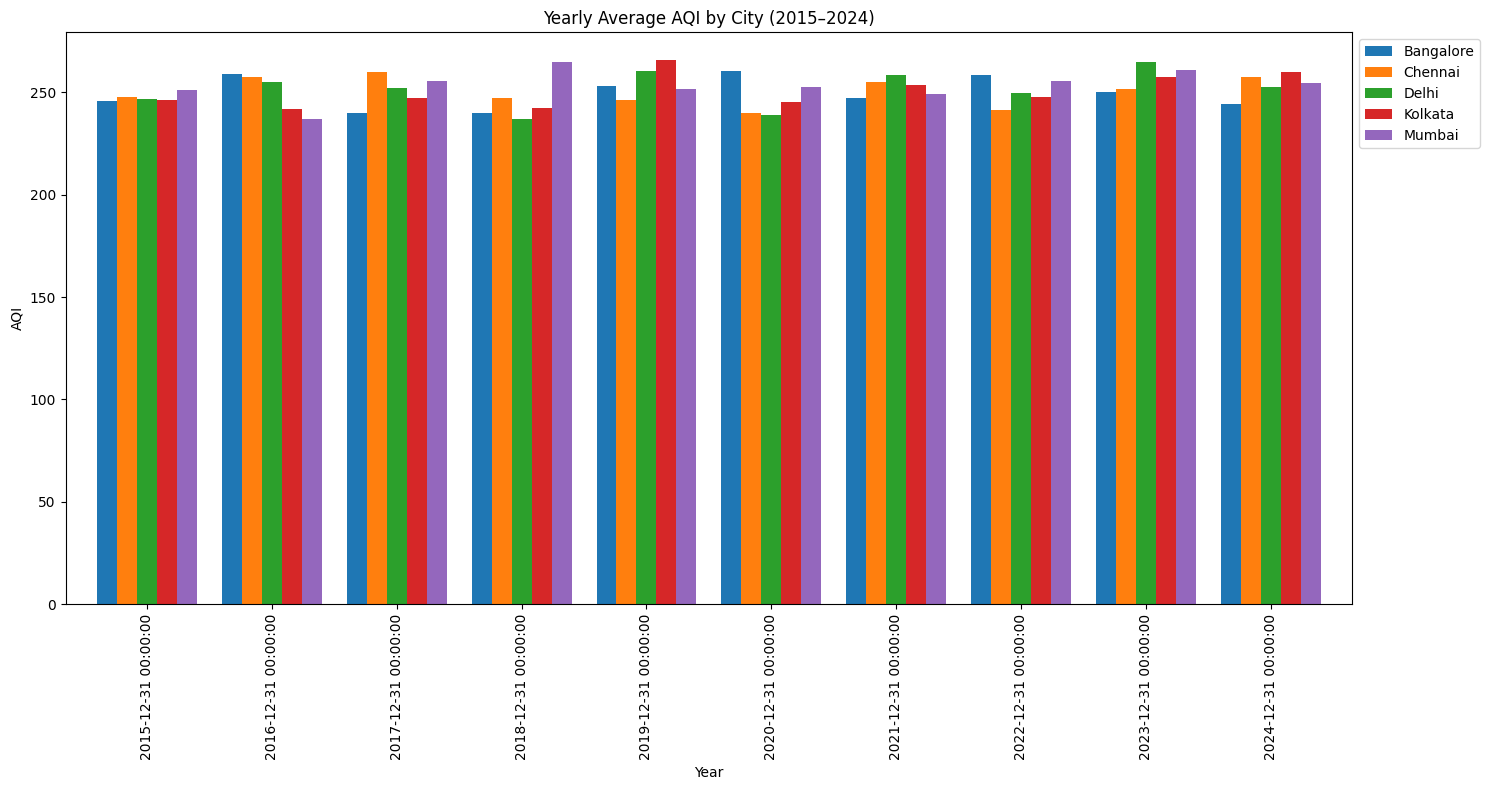

In [88]:
# --- Step 1: Aggregate to yearly averages per city ---
df_yearly = (
    df_city.set_index("Datetime")
    .groupby("City")["AQI"]
    .resample("YE").mean()
    .reset_index()
)

# Filter only your 15 chosen cities
cities = ["Delhi", "Mumbai", "Bangalore", "Chennai", "Kolkata",
          "Pune", "Hyderabad", "Ahmedabad", "Jaipur", "Lucknow",
          "Bhopal", "Patna", "Chandigarh", "Agra", "Kanpur"]

df_yearly = df_yearly[df_yearly["City"].isin(cities)]

# --- Step 2: Pivot for bar chart ---
df_pivot = df_yearly.pivot(index="Datetime", columns="City", values="AQI")

# --- Step 3: Plot grouped bar chart ---
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
df_pivot.plot(kind="bar", figsize=(15,8), width=0.8)

plt.title("Yearly Average AQI by City (2015–2024)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


## Step 3 —Deeper Preprocessing / EDA
Data Cleaning & Schema Mapping


### Missing-values analysis

=== Overall missing by pollutant ===


,missing_count,missing_pct
PM2.5,0,0.0
PM10,0,0.0
NO,0,0.0
NO2,0,0.0
NOx,0,0.0
NH3,0,0.0
CO,0,0.0
SO2,0,0.0
O3,0,0.0
Benzene,0,0.0



=== Missing % by City (first 10 rows) ===


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
City,,,,,,,,,,,,,
Bangalore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chennai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Delhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kolkata,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mumbai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Pollutants with > 50.0% missing: []

=== Yearly % non-null for pollutants (head) ===


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
Year,,,,,,,,,,,,,
2015,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2016,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2017,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2018,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2019,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


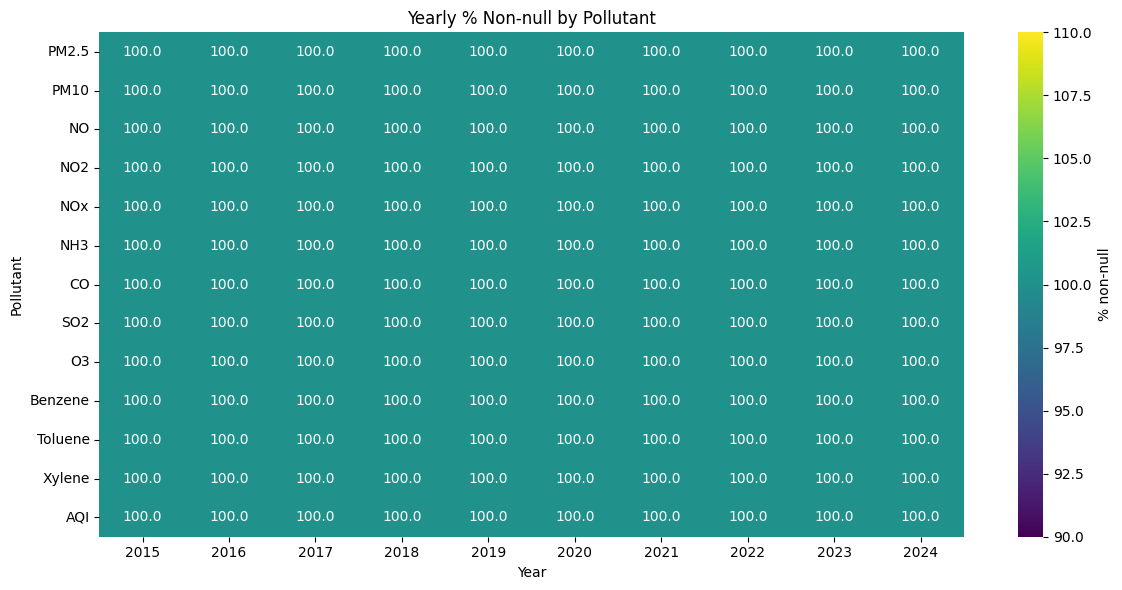


Top cities by missing AQI %:
City
Bangalore    0.0
Chennai      0.0
Delhi        0.0
Kolkata      0.0
Mumbai       0.0
Name: AQI, dtype: float64


In [89]:
# Step 1: Missing-values analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# assume df_filtered exists (your filtered dataset for 15 cities)
# if not, reload df_filtered as per earlier steps

pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene','AQI']

# 1) Overall missing counts and percentage
miss_counts = df_filtered[pollutants].isna().sum()
miss_pct = (miss_counts / len(df_filtered) * 100).round(2)
missing_df = pd.DataFrame({'missing_count': miss_counts, 'missing_pct': miss_pct}).sort_values('missing_pct', ascending=False)
print("=== Overall missing by pollutant ===")
display(missing_df)

# save
missing_df.to_csv('/content/data/missing_by_pollutant.csv')

# 2) Missing % by city (each pollutant)
miss_city = (df_filtered.groupby('City')[pollutants]
             .apply(lambda g: g.isna().mean()*100)
             .round(2))
print("\n=== Missing % by City (first 10 rows) ===")
display(miss_city.head(10))
miss_city.to_csv('/content/data/missing_by_city.csv')

# 3) Which pollutants are very sparse?
sparse_thresh = 50.0   # percent missing threshold you can adjust
sparse_pollutants = missing_df[missing_df['missing_pct'] > sparse_thresh].index.tolist()
print("\nPollutants with > {}% missing: {}".format(sparse_thresh, sparse_pollutants))

# 4) Yearly coverage (percent non-null) per pollutant -> heatmap
df_tmp = df_filtered.copy()
df_tmp['Year'] = df_tmp['Datetime'].dt.year

# compute % non-null per year & pollutant
yearly_coverage = df_tmp.groupby('Year')[pollutants].apply(lambda x: x.notna().mean()*100).round(2)
print("\n=== Yearly % non-null for pollutants (head) ===")
display(yearly_coverage.head())

# plot heatmap (pollutants on y-axis, years on x-axis)
plt.figure(figsize=(12,6))
sns.heatmap(yearly_coverage.T, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label':'% non-null'})
plt.title("Yearly % Non-null by Pollutant")
plt.xlabel("Year")
plt.ylabel("Pollutant")
plt.tight_layout()
plt.show()

# save yearly coverage
yearly_coverage.to_csv('/content/data/yearly_coverage.csv')

# 5) Optional: print cities with worst missingness for AQI specifically
print("\nTop cities by missing AQI %:")
print(miss_city['AQI'].sort_values(ascending=False).head(10))


### Outlier detection & handling

=== Summary stats (including 1% and 99%) ===


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
PM2.5,18265.0,250.597695,144.460292,0.0,5.400,24.70,125.70,251.00,376.20,475.40,494.3360,499.9
PM10,18265.0,299.442491,173.479906,0.0,5.900,29.30,150.10,300.30,450.00,569.90,594.0360,600.0
NO,18265.0,100.481035,57.774795,0.0,1.900,10.32,50.60,100.20,151.00,190.40,197.8360,200.0
NO2,18265.0,75.415916,43.460066,0.0,1.600,7.60,37.70,76.00,113.20,142.40,148.3000,150.0
NOx,18265.0,125.964079,72.403893,0.0,2.500,13.12,63.10,126.20,188.90,238.00,247.7000,250.0
NH3,18265.0,25.065042,14.452019,0.0,0.500,2.50,12.60,25.30,37.60,47.50,49.5000,50.0
CO,18265.0,5.002451,2.889439,0.0,0.110,0.52,2.49,5.00,7.51,9.50,9.9000,10.0
SO2,18265.0,49.835839,28.988739,0.0,1.000,5.02,24.40,49.90,75.10,95.00,99.0000,100.0
O3,18265.0,100.406740,57.591436,0.0,2.000,10.02,50.60,100.70,150.40,190.20,197.9000,200.0
Benzene,18265.0,10.070033,5.785282,0.0,0.170,1.01,5.08,10.08,15.11,19.04,19.8100,20.0



=== Outliers by IQR method (global) ===


,pollutant,lower_iqr,upper_iqr,count_below,count_above,count_negative
0,PM2.5,-250.050,751.950,0,0,0
1,PM10,-299.750,899.850,0,0,0
2,NO,-100.000,301.600,0,0,0
3,NO2,-75.550,226.450,0,0,0
4,NOx,-125.600,377.600,0,0,0
5,NH3,-24.900,75.100,0,0,0
6,CO,-5.040,15.040,0,0,0
7,SO2,-51.650,151.150,0,0,0
8,O3,-99.100,300.100,0,0,0
9,Benzene,-9.965,30.155,0,0,0



=== Extreme counts by 1%/99% percentiles ===


,pollutant,p1,p99,count_below_p1,count_above_p99
0,PM2.5,5.400,494.3360,180,183
1,PM10,5.900,594.0360,181,183
2,NO,1.900,197.8360,181,183
3,NO2,1.600,148.3000,179,181
4,NOx,2.500,247.7000,178,181
5,NH3,0.500,49.5000,168,168
6,CO,0.110,9.9000,174,174
7,SO2,1.000,99.0000,171,182
8,O3,2.000,197.9000,181,178
9,Benzene,0.170,19.8100,182,178



Total rows flagged as outliers (any pollutant): 4105
Outlier rows shape: (4105, 30)


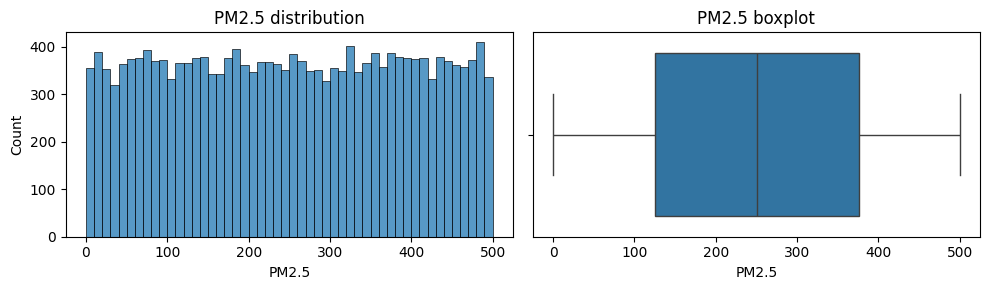

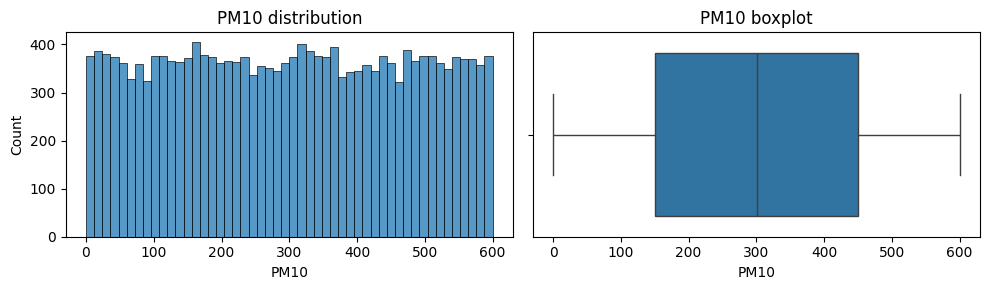

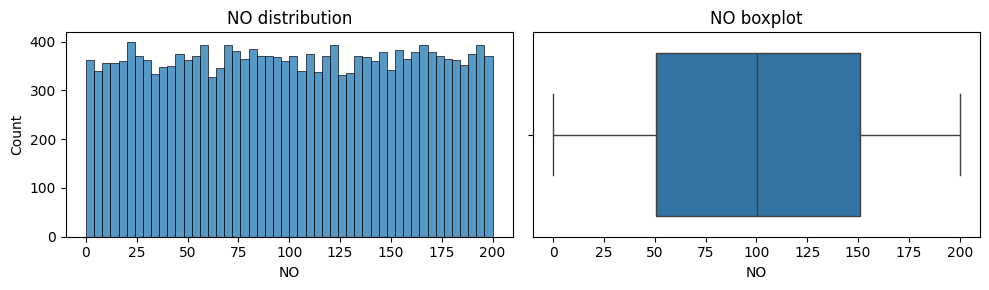

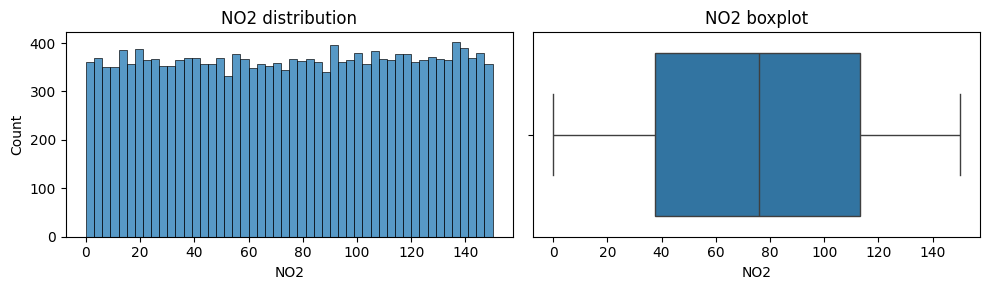

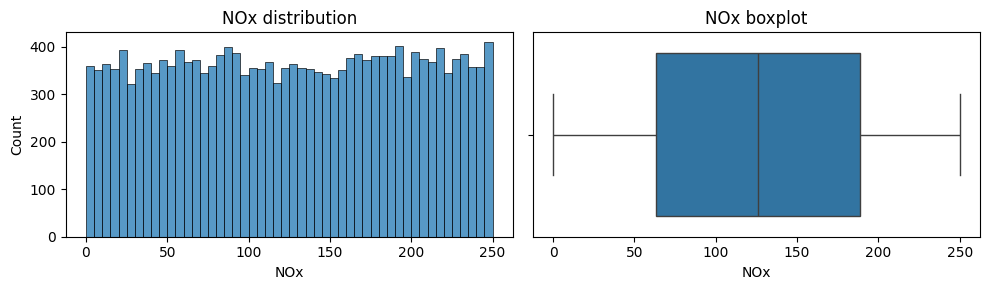

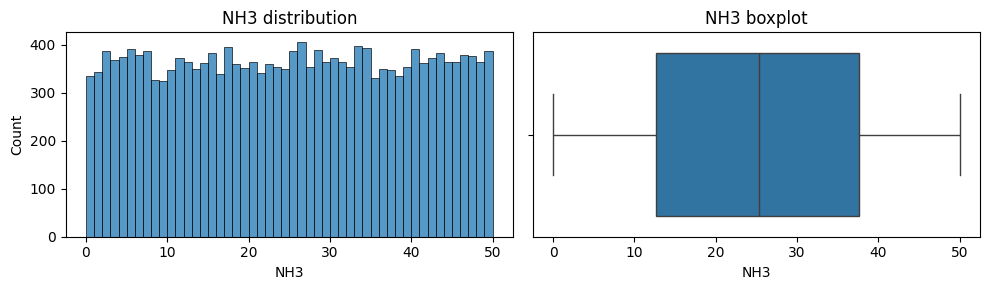

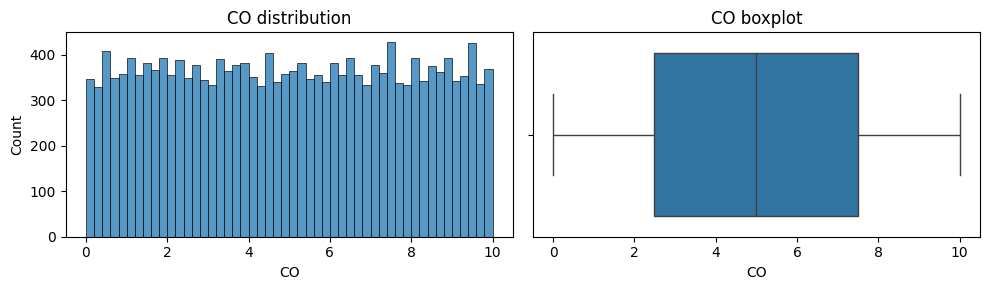

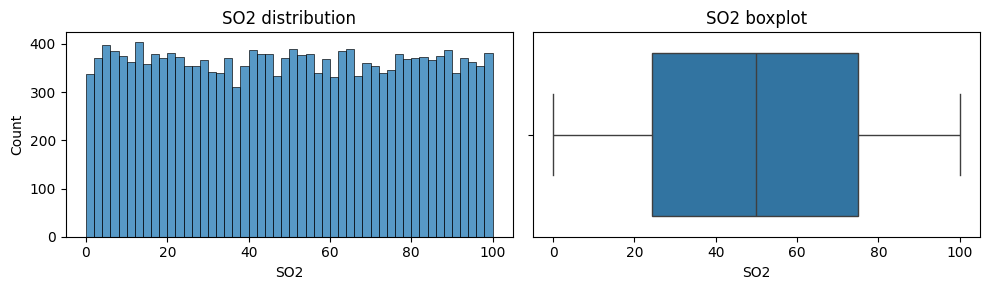

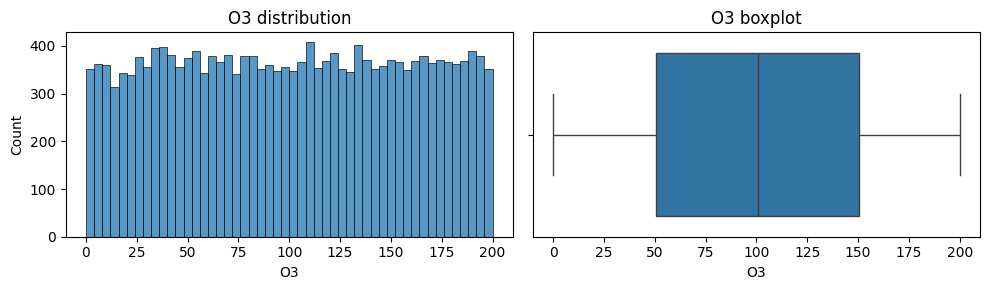

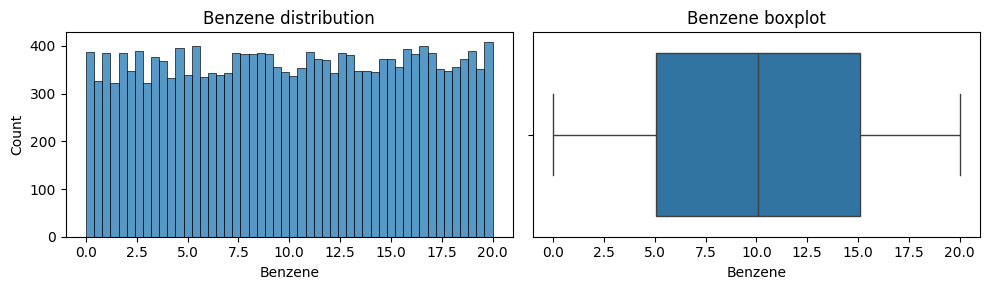

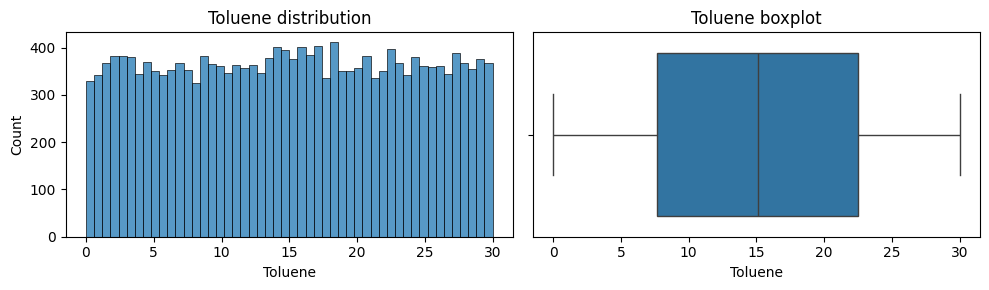

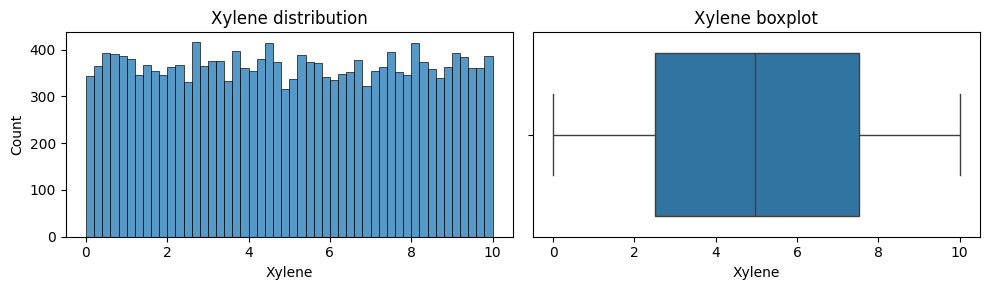

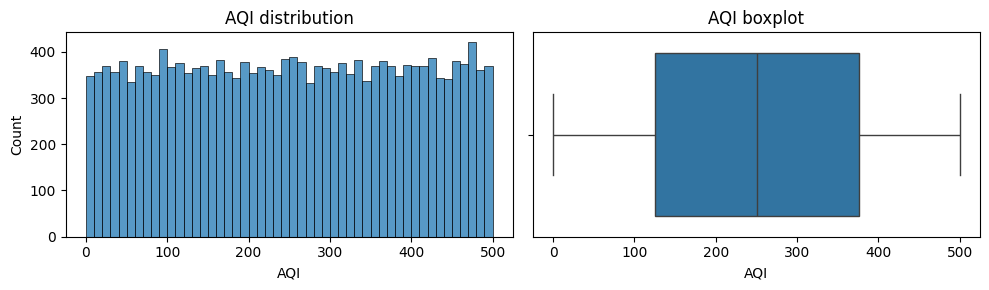


Saved 'outlier_rows.csv' (flagged rows) and 'df_clean_winsorized.csv' (1%/99% clipped copy).
If you prefer stricter clipping (0.5/99.5) or to remove rows, tell me and I will generate that version.

--- quick summary to paste ---


,pollutant,lower_iqr,upper_iqr,count_below,count_above,count_negative
0,PM2.5,-250.050,751.950,0,0,0
1,PM10,-299.750,899.850,0,0,0
2,NO,-100.000,301.600,0,0,0
3,NO2,-75.550,226.450,0,0,0
4,NOx,-125.600,377.600,0,0,0
5,NH3,-24.900,75.100,0,0,0
6,CO,-5.040,15.040,0,0,0
7,SO2,-51.650,151.150,0,0,0
8,O3,-99.100,300.100,0,0,0
9,Benzene,-9.965,30.155,0,0,0


,pollutant,p1,p99,count_below_p1,count_above_p99
0,PM2.5,5.400,494.3360,180,183
1,PM10,5.900,594.0360,181,183
2,NO,1.900,197.8360,181,183
3,NO2,1.600,148.3000,179,181
4,NOx,2.500,247.7000,178,181
5,NH3,0.500,49.5000,168,168
6,CO,0.110,9.9000,174,174
7,SO2,1.000,99.0000,171,182
8,O3,2.000,197.9000,181,178
9,Benzene,0.170,19.8100,182,178


Total flagged rows: 4105


,City,Datetime,AQI,PM2.5_flag,PM10_flag,NO_flag,NO2_flag,NOx_flag,NH3_flag,CO_flag,SO2_flag,O3_flag,Benzene_flag,Toluene_flag,Xylene_flag,AQI_flag
4,Bangalore,2015-01-01,489.7,False,False,False,False,False,True,False,False,False,False,False,False,False
7,Chennai,2015-01-02,171.7,False,False,False,False,False,False,False,False,True,False,False,False,False
8,Kolkata,2015-01-02,139.8,False,True,False,False,False,False,False,False,False,False,False,False,False
9,Bangalore,2015-01-02,243.3,False,False,False,False,False,False,True,False,False,False,False,False,False
10,Delhi,2015-01-03,77.6,False,False,False,False,False,False,True,False,False,False,False,False,False
12,Chennai,2015-01-03,394.8,False,False,False,False,False,True,False,False,False,False,False,False,False
15,Delhi,2015-01-04,85.4,False,False,True,False,False,False,False,False,False,False,False,False,False
16,Mumbai,2015-01-04,78.5,False,False,False,True,False,False,False,False,False,False,False,False,False
26,Mumbai,2015-01-06,496.9,False,False,False,False,False,False,False,False,False,False,False,False,True
32,Chennai,2015-01-07,0.7,False,False,False,False,False,False,False,False,False,False,False,False,True


In [90]:
# === Step 2: Outlier detection & handling ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# use your filtered dataset of 15 cities
df = df_filtered.copy()   # keep original name safe

pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene','AQI']

# 1) Basic summary stats & percentiles
summary = df[pollutants].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
summary = summary[['count','mean','std','min','1%','5%','25%','50%','75%','95%','99%','max']]
print("=== Summary stats (including 1% and 99%) ===")
display(summary)

# 2) IQR-based outlier detection (global, across all cities)
outlier_info = []
for col in pollutants:
    series = df[col].dropna()
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_lower = (df[col] < lower).sum()
    n_upper = (df[col] > upper).sum()
    n_neg = (df[col] < 0).sum() if (df[col].dtype.kind in 'fc') else 0
    outlier_info.append((col, lower, upper, n_lower, n_upper, n_neg))
outlier_df = pd.DataFrame(outlier_info, columns=['pollutant','lower_iqr','upper_iqr','count_below','count_above','count_negative'])
print("\n=== Outliers by IQR method (global) ===")
display(outlier_df)

# 3) Percentile-based extreme counts (1% & 99%)
pct_info = []
for col in pollutants:
    s = df[col].dropna()
    p1 = s.quantile(0.01)
    p99 = s.quantile(0.99)
    n_below = (df[col] < p1).sum()
    n_above = (df[col] > p99).sum()
    pct_info.append((col, p1, p99, n_below, n_above))
pct_df = pd.DataFrame(pct_info, columns=['pollutant','p1','p99','count_below_p1','count_above_p99'])
print("\n=== Extreme counts by 1%/99% percentiles ===")
display(pct_df)

# 4) Create a combined flag DataFrame of rows that are extreme by either method
flags = []
for col in pollutants:
    lower_iqr = outlier_df.loc[outlier_df['pollutant']==col,'lower_iqr'].values[0]
    upper_iqr = outlier_df.loc[outlier_df['pollutant']==col,'upper_iqr'].values[0]
    p1 = pct_df.loc[pct_df['pollutant']==col,'p1'].values[0]
    p99 = pct_df.loc[pct_df['pollutant']==col,'p99'].values[0]
    # flag if below p1 or above p99 OR outside IQR fences, or negative
    cond = (df[col].notna()) & ((df[col] < p1) | (df[col] > p99) | (df[col] < lower_iqr) | (df[col] > upper_iqr) | (df[col] < 0))
    flags.append(cond.rename(col + "_flag"))

flag_df = pd.concat(flags, axis=1)
flag_df['any_outlier'] = flag_df.any(axis=1)

print("\nTotal rows flagged as outliers (any pollutant):", flag_df['any_outlier'].sum())

# attach flags to df
df_out = df.copy()
df_out = pd.concat([df_out.reset_index(drop=True), flag_df.reset_index(drop=True)], axis=1)

# Save outlier rows for inspection
df_outliers = df_out[df_out['any_outlier']].copy()
print("Outlier rows shape:", df_outliers.shape)
df_outliers.head(10)

# Save to disk for manual inspection
df_outliers.to_csv('/content/data/outlier_rows.csv', index=False)

# 5) Visual checks: distribution & boxplot for each pollutant (compact)
plt.rcParams.update({'figure.max_open_warning': 0})
for col in pollutants:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    sns.histplot(df[col].dropna(), bins=50, kde=False)
    plt.title(f"{col} distribution")
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col].dropna())
    plt.title(f"{col} boxplot")
    plt.tight_layout()
    plt.show()

# 6) Handling options (choose one). Default: winsorize at 1%/99%
# Option A: Winsorize/clip at 1% and 99% (recommended quick approach)
df_clean = df.copy()
for col in pollutants:
    if col in df_clean.columns:
        p1 = df_clean[col].quantile(0.01)
        p99 = df_clean[col].quantile(0.99)
        df_clean[col] = df_clean[col].clip(lower=p1, upper=p99)

# Save cleaned dataframe (winsorized)
df_clean.to_csv('/content/data/df_clean_winsorized.csv', index=False)

# Option B (alternative): keep original values but add 'is_outlier' flag for model to learn
# (we already have df_out with flags saved as outlier_rows.csv)

print("\nSaved 'outlier_rows.csv' (flagged rows) and 'df_clean_winsorized.csv' (1%/99% clipped copy).")
print("If you prefer stricter clipping (0.5/99.5) or to remove rows, tell me and I will generate that version.")

# Quick summary printouts for you to paste back
print("\n--- quick summary to paste ---")
display(outlier_df)   # IQR fences and counts
display(pct_df)       # 1%/99% percentiles and counts
print("Total flagged rows:", df_outliers.shape[0])
df_outliers[['City','Datetime','AQI'] + [c for c in df_outliers.columns if c.endswith('_flag')]].head(10)


### AQI category distribution & class balance.

#### (A) Overall Class Balance

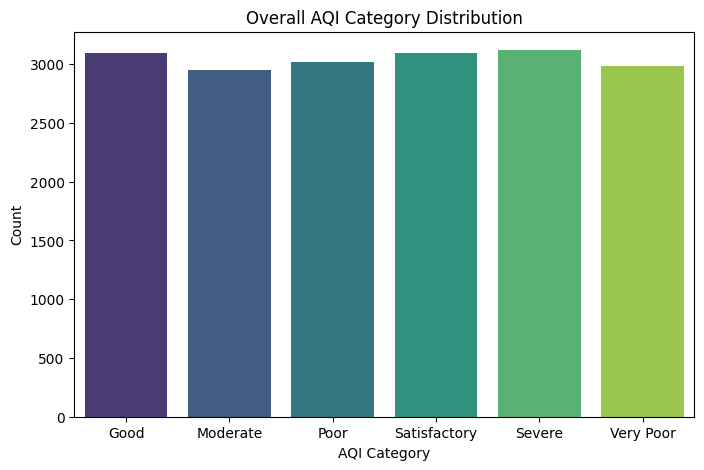

In [91]:
# Class distribution
bucket_counts = df_clean['AQI_Bucket'].value_counts().sort_index()

# Plot fixed (no warning)
plt.figure(figsize=(8,5))
sns.barplot(
    x=bucket_counts.index,
    y=bucket_counts.values,
    hue=bucket_counts.index,  # use AQI category as hue
    dodge=False,
    palette=sns.color_palette("viridis", n_colors=len(bucket_counts)),
    legend=False  # don't need legend since labels are on x-axis
)
plt.title("Overall AQI Category Distribution")
plt.ylabel("Count")
plt.xlabel("AQI Category")
plt.show()

#### (B) City-Wise AQI Bucket Distribution

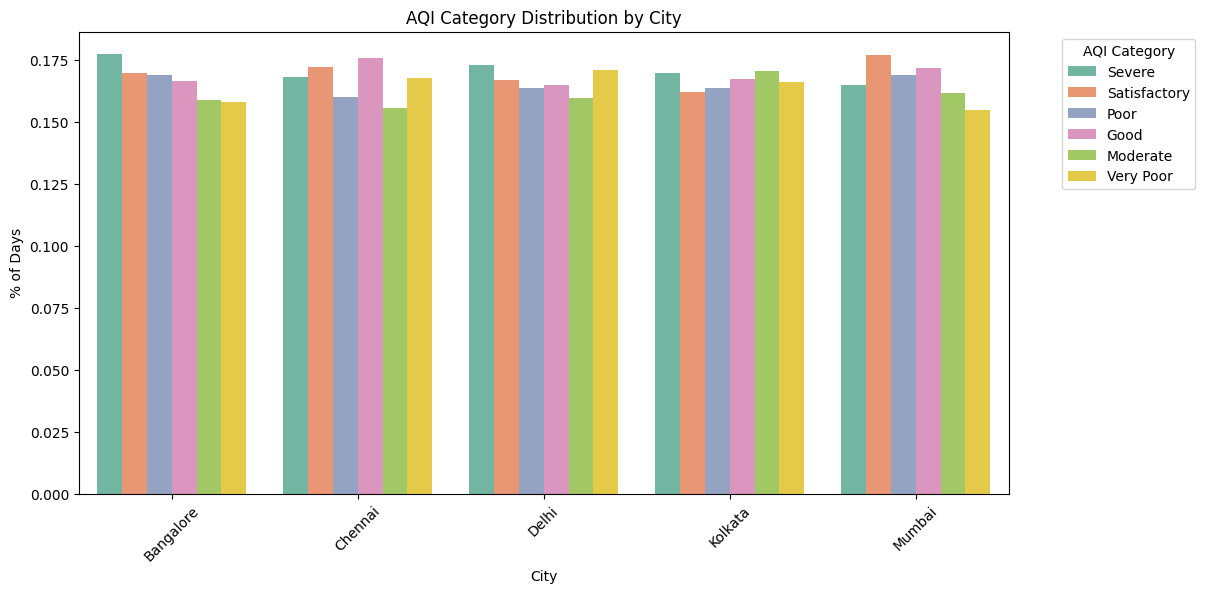

In [92]:
# Percentage distribution per city
city_bucket = (df_clean.groupby("City")['AQI_Bucket']
               .value_counts(normalize=True)
               .rename("percent")
               .reset_index())

plt.figure(figsize=(12,6))
sns.barplot(
    x="City",
    y="percent",
    hue="AQI_Bucket",
    data=city_bucket,
    palette="Set2"
)
plt.title("AQI Category Distribution by City")
plt.ylabel("% of Days")
plt.xticks(rotation=45)
plt.legend(title="AQI Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


#### (C) Pie Chart (Optional – overall balance)

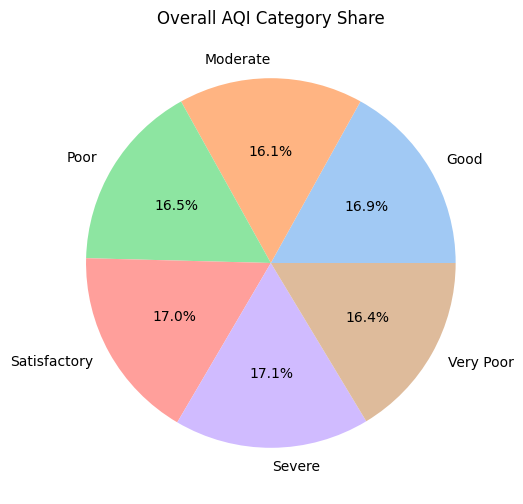

In [93]:
plt.figure(figsize=(6,6))
plt.pie(
    bucket_counts,
    labels=bucket_counts.index,
    autopct='%1.1f%%',
    colors=sns.color_palette("pastel", n_colors=len(bucket_counts))
)
plt.title("Overall AQI Category Share")
plt.show()


## Step 4 -Correlation Analysis

In [94]:
import pandas as pd
from scipy.stats.mstats import winsorize

# Use the already loaded dataset
df_clean_winsorized = df_city.copy()

# List of pollutant columns
pollutants = ['AQI', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# Convert to numeric (invalid entries become NaN)
for col in pollutants:
    df_clean_winsorized[col] = pd.to_numeric(df_clean_winsorized[col], errors='coerce')

# Winsorize numeric columns to handle outliers
for col in pollutants:
    df_clean_winsorized[col] = winsorize(df_clean_winsorized[col], limits=[0.01, 0.01])

# Drop rows with missing values for correlation
df_corr = df_clean_winsorized[pollutants].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Show correlations with AQI
print(corr_matrix['AQI'].sort_values(ascending=False))


AQI      1.000000
NO2      0.011145
CO       0.006067
SO2      0.002946
PM10     0.001241
PM2.5    0.000646
O3       0.000554
Name: AQI, dtype: float64


In [95]:
# Check fraction of missing values
df_clean_winsorized[pollutants].isna().mean()


,0
AQI,0.0
PM2.5,0.0
PM10,0.0
SO2,0.0
NO2,0.0
CO,0.0
O3,0.0


In [96]:
# Quick peek at numeric values
df_clean_winsorized[['AQI', 'PM2.5', 'PM10']].head(10)


,AQI,PM2.5,PM10
0,204.5,153.3,241.7
1,60.9,70.5,312.7
2,486.5,174.1,275.4
3,174.4,477.2,543.9
4,489.7,171.6,117.7
5,238.5,344.2,173.2
6,254.9,59.2,335.7
7,171.7,418.9,573.8
8,139.8,329.8,594.1
9,243.3,22.5,317.5


In [102]:
df_corr = df_clean_winsorized[['AQI', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']].dropna()
corr_matrix = df_corr.corr()
print(corr_matrix['AQI'].sort_values(ascending=False))


AQI      1.000000
NO2      0.011145
CO       0.006067
SO2      0.002946
PM10     0.001241
PM2.5    0.000646
O3       0.000554
Name: AQI, dtype: float64


In [105]:
import numpy as np

# Numeric pollutant columns
pollutants = ['AQI', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

df_numeric = df_clean_winsorized[pollutants].copy()

# Optional: log-transform to reduce effect of extreme values
for col in pollutants:
    df_numeric[col] = np.log1p(df_numeric[col])

# Compute correlation
corr_matrix = df_numeric.corr()
print(corr_matrix['AQI'].sort_values(ascending=False))


AQI      1.000000
NO2      0.014385
CO       0.005280
SO2     -0.001714
O3      -0.003190
PM10    -0.003524
PM2.5   -0.005278
Name: AQI, dtype: float64


In [104]:
from scipy.stats.mstats import winsorize

for col in ['AQI', 'PM2.5', 'PM10']:
    df_corr[col] = winsorize(df_corr[col], limits=[0.05, 0.05])
